In [1]:
import gym
import torch
import sys
import os
import random
import numpy as np
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
sys.path.append('../')
from common import make_env
sys.path.append('../../')
import TD3

import pandas as pd

if not os.path.exists("images"):
    os.mkdir("images")
    
if not os.path.exists("images2"):
    os.mkdir("images2")

In [2]:
response_times = [ 0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28]

In [5]:
for rt in response_times:
    for g_force in range(21):
        for seed in range(5):
            if not os.path.isfile('../models/TD3_InvertedPendulum-v2_'+str(seed)+'_0.02_'+str(float(g_force))+'_'+str(rt)+'_1.0_False_final_actor'):
                print (rt, g_force, seed)

0.01 3 1
0.01 3 3
0.01 4 3
0.01 4 4
0.01 5 3
0.02 4 4
0.04 2 2
0.04 2 3
0.04 3 0
0.04 3 4
0.04 4 2
0.04 5 3
0.16 3 4
0.32 3 4
0.64 0 0
0.64 0 1
0.64 0 2
0.64 0 3
0.64 0 4
0.64 1 0
0.64 1 1
0.64 1 2
0.64 1 3
0.64 1 4
0.64 2 0
0.64 2 1
0.64 2 2
0.64 2 3
0.64 2 4
0.64 3 0
0.64 3 1
0.64 3 2
0.64 3 3
0.64 3 4
0.64 4 0
0.64 4 1
0.64 4 2
0.64 4 3
0.64 4 4
0.64 5 0
0.64 5 1
0.64 5 2
0.64 5 3
0.64 5 4
1.28 0 0
1.28 0 1
1.28 0 2
1.28 0 3
1.28 0 4
1.28 1 0
1.28 1 1
1.28 1 2
1.28 1 3
1.28 1 4
1.28 2 0
1.28 2 1
1.28 2 2
1.28 2 3
1.28 2 4
1.28 3 0
1.28 3 1
1.28 3 2
1.28 3 3
1.28 3 4
1.28 4 0
1.28 4 1
1.28 4 2
1.28 4 3
1.28 4 4
1.28 5 0
1.28 5 1
1.28 5 2
1.28 5 3
1.28 5 4


In [7]:
df = pd.DataFrame(columns=['seed', 'g_force', 'response_rate', 'reward', 'angle', 'jerk'])
# df = torch.load('dataframe')
default_timestep = 0.02
default_frame_skip = 2
jit_duration = 0.02
env_name = 'InvertedPendulum-v2'
for response_rate in response_times:
    for g_force in range(21):
        print(response_rate, g_force)
        for seed in range(5):
            states = []
            force = g_force * 9.81
            arguments = ['TD3', env_name, seed, jit_duration, float(g_force), response_rate, 1.0, False,'final']
                # Target policy smoothing is scaled wrt the action scale
            file_name = '_'.join([str(x) for x in arguments])
            if response_rate % default_timestep == 0:
                frame_skip = response_rate / default_timestep
                timestep = default_timestep
            elif jit_duration < response_rate:
                timestep = jit_duration
                frame_skip = response_rate / timestep
            else:
                timestep = response_rate
                frame_skip = 1
            jit_frames = 0  # How many frames the horizontal jitter force lasts each time
            if jit_duration:
                if jit_duration % timestep == 0:
                    jit_frames = int(jit_duration / timestep)
                else:
                    raise ValueError(
                        "jit_duration should be a multiple of the timestep: " + str(timestep))
                    
            time_change_factor = (default_timestep * default_frame_skip) / (timestep * frame_skip)
            eval_env = make_env(env_name, seed, time_change_factor, timestep, frame_skip, False)
            eval_env._max_episode_steps = 100000
            state_dim = eval_env.observation_space.shape[0]
            action_dim = eval_env.action_space.shape[0]
            max_action = float(eval_env.action_space.high[0])
            kwargs = {
                "state_dim": state_dim,
                "action_dim": action_dim,
                "observation_space": eval_env.observation_space,
                "max_action": max_action,
                "discount": 0.99,
                "tau": 0.005,
            }
            kwargs["policy_noise"] = 2 * max_action
            kwargs["noise_clip"] = 0.5 * max_action
            kwargs["policy_freq"] = 2
            policy = TD3.TD3(**kwargs)
            policy_file = file_name 
            if os.path.exists('../models/'+policy_file+"_critic"):
                policy.load(f"../models/{policy_file}")
                avg_reward = 0.
                avg_angle = 0.
                steps = 0

                t = 0
                forces = []
                force_times = []
                for _ in range(1):
                    state, done = eval_env.reset(), False
                    eval_env.model.opt.gravity[0] = 0
                    counter = 0
                    disturb = 5
                    jittering = False
                    force = 0.25
                    prev_action = None
                    jerk = 0
                    while not done:
                        action = policy.select_action(np.array(state))
                        # Perform action
                        if not jittering and round(disturb - counter, 3) >= response_rate:  # Not during the frames when jitter force keeps existing
                            next_state, reward, done, _ = eval_env.step(action)
                            counter += response_rate
                        elif not jittering and round(disturb - counter, 3) < response_rate:
                            forces.append(force)
                            force_times.append(t)
                            jitter_force = force * 9.81 * (2 * (np.random.random() > 0.5) - 1)  # Jitter force strength w/ direction
                            next_state, reward, done, _ = eval_env.jitter_step_start(action, jitter_force,
                                                                                     (disturb - counter) / timestep,
                                                                                     frame_skip - ((disturb - counter) / timestep),
                                                                                     jit_frames)
                            jittered_frames = frame_skip - ((disturb - counter) / timestep)
                            if jittered_frames >= jit_frames:
                                jittered_frames = 0
                                jittering = False
                                eval_env.model.opt.gravity[0] = 0
                                counter = 0
                                force += 0.25

                            else:
                                jittering = True
                                eval_env.model.opt.gravity[0] = jitter_force
                                counter += response_rate
                        elif jit_frames - jittered_frames < frame_skip:  # Jitter force will dispear from now!
                            next_state, reward, done, _ = eval_env.jitter_step_end(
                                action, jitter_force, jit_frames - jittered_frames, frame_skip - (jit_frames - jittered_frames))
                            jittering = False  # Stop jittering now
                            eval_env.model.opt.gravity[0] = 0
                            counter = 0
                            force += 0.25
                        else:  # Jitter force keeps existing now!
                            next_state, reward, done, _ = eval_env.step(action)
                            jittered_frames += frame_skip
                            counter += response_rate
                            if jittered_frames == jit_frames:
                                jittering = False
                                eval_env.model.opt.gravity[0] = 0
                                counter = 0
                                force += 0.25

                        avg_reward += reward
                        avg_angle += abs(next_state[1])
                        state = next_state
                        counter = round(counter, 3)
                        if jit_duration:
                            if counter == disturb:
                                forces.append(force)
                                force_times.append(t)
                                jitter_force = force * 9.81 * (2 * (random.random() > 0.5) - 1)
                                eval_env.model.opt.gravity[0] = jitter_force
                                jittering = True
                                jittered_frames = 0

                        t += 1
                        if prev_action:
                            jerk += abs(action[0] - prev_action)
                        prev_action = action[0]
                        states.append(state)
                states = np.array(states)
                fig = make_subplots(rows=2, cols=1)
                x = [i for i in range(t)]
                for index, f in enumerate(force_times):
                    fig.add_shape(go.layout.Shape(type="line",
                                            x0=f,
                                            y0=-100,
                                            x1=f,
                                            y1=100,
                                            ),row=1,col=1)
                    fig.add_annotation(x=f,
                                       y=0,
                                       text=str(forces[index]), 
                                       showarrow=False,
                                       row=1, col=1)
                fig.add_trace(go.Scatter(x=x, y=states[:,0], mode='lines', name='pos'), row=1, col=1)
                fig.add_trace(go.Scatter(x=x, y=states[:,1], mode='lines', name='angle'), row=2, col=1)
    #             fig.add_trace(go.Scatter(x=x, y=states[:,2], mode='lines', name='vel'))
    #             fig.add_trace(go.Scatter(x=x, y=states[:,3], mode='lines', name='angular vel'))
                fig.update_layout(xaxis_title="Frames")

                fig.write_html("images2/"+file_name+'.html')
        

                avg_reward /= 1
                avg_angle /= 1
                jerk /= avg_reward
                df.loc[len(df.index)] = [seed, g_force, response_rate, avg_reward, avg_angle, jerk]
                

0.01 0
0.01 1
0.01 2
0.01 3
0.01 4
0.01 5
0.01 6
0.01 7
0.01 8
0.01 9
0.01 10
0.01 11
0.01 12
0.01 13
0.01 14
0.01 15
0.01 16
0.01 17
0.01 18
0.01 19
0.01 20
0.02 0
0.02 1
0.02 2
0.02 3
0.02 4
0.02 5
0.02 6
0.02 7
0.02 8
0.02 9
0.02 10
0.02 11
0.02 12
0.02 13
0.02 14
0.02 15
0.02 16
0.02 17
0.02 18
0.02 19
0.02 20
0.04 0
0.04 1
0.04 2
0.04 3
0.04 4
0.04 5
0.04 6
0.04 7
0.04 8
0.04 9
0.04 10
0.04 11
0.04 12
0.04 13
0.04 14
0.04 15
0.04 16
0.04 17
0.04 18
0.04 19
0.04 20
0.08 0
0.08 1
0.08 2
0.08 3
0.08 4
0.08 5
0.08 6
0.08 7
0.08 8
0.08 9
0.08 10
0.08 11
0.08 12
0.08 13
0.08 14
0.08 15
0.08 16
0.08 17
0.08 18
0.08 19
0.08 20
0.16 0
0.16 1
0.16 2
0.16 3
0.16 4
0.16 5
0.16 6
0.16 7
0.16 8
0.16 9
0.16 10
0.16 11
0.16 12
0.16 13
0.16 14
0.16 15
0.16 16
0.16 17
0.16 18
0.16 19
0.16 20
0.32 0
0.32 1
0.32 2
0.32 3
0.32 4
0.32 5
0.32 6
0.32 7
0.32 8
0.32 9
0.32 10
0.32 11
0.32 12
0.32 13
0.32 14
0.32 15
0.32 16
0.32 17
0.32 18
0.32 19
0.32 20
0.64 0
0.64 1
0.64 2
0.64 3
0.64 4
0.64 5
0.64 6
0.6

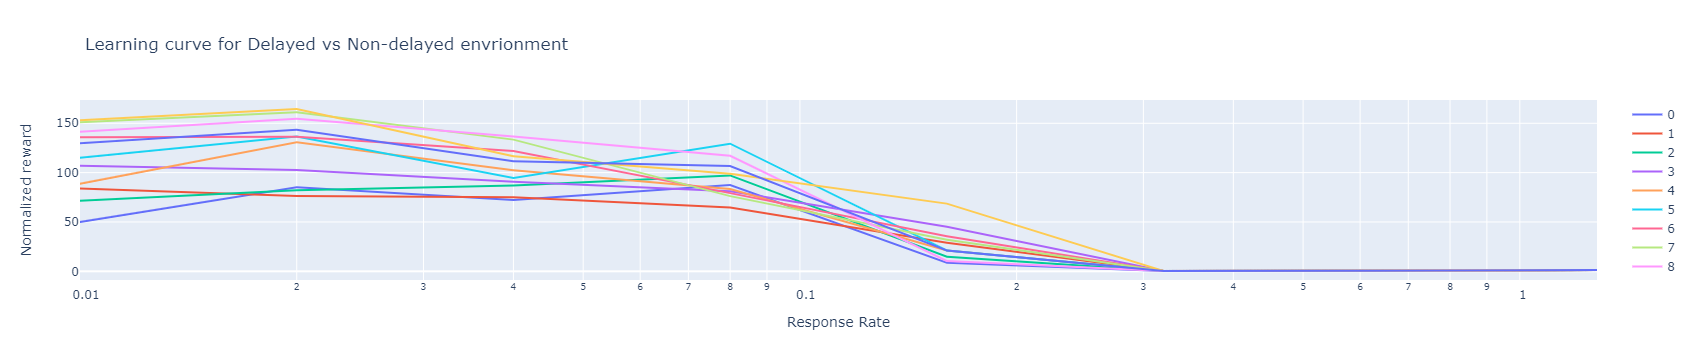

In [18]:
fig = go.Figure()

    
for force in range(11):
    rewards = []
    for rt in response_times:
        temp_df = df.loc[(df['response_rate'] == rt) & (df['g_force'] == force)]
#         print (rt, force, np.mean(temp_df['reward'])* rt)
        rewards.append( np.mean(temp_df['reward'])* rt)
    
    fig.add_trace(go.Scatter(x=response_times, y=rewards, mode='lines', name=str(force)))
    
fig.update_xaxes(type="log")
fig.update_layout(title='Learning curve for Delayed vs Non-delayed envrionment',
                   xaxis_title='Response Rate',
                   yaxis_title='Normalized reward')

fig.show()

In [8]:
df

seed  g_force  response_rate   reward        angle      jerk
0     0.0      0.0           0.01   2575.0    57.464094  0.145602
1     1.0      0.0           0.01    120.0    17.372309  2.128507
2     2.0      0.0           0.01   5111.0   116.022450  0.626183
3     3.0      0.0           0.01   5570.0    98.811796  1.483030
4     4.0      0.0           0.01   7675.0   172.453000  3.613772
5     0.0      1.0           0.01   5600.0    53.974767  0.428644
6     1.0      1.0           0.01  15606.0   413.308436  1.991898
7     2.0      1.0           0.01   6036.0    83.613548  0.229315
8     3.0      1.0           0.01   7049.0   177.905659  0.489654
9     4.0      1.0           0.01  11128.0   390.819119  2.596713
10    0.0      2.0           0.01   6552.0    79.249167  0.409481
11    1.0      2.0           0.01   9637.0   596.471585  3.776713
12    2.0      2.0           0.01   8040.0   276.803810  1.661298
13    3.0      2.0           0.01   7555.0   171.862069  0.935410
14    4.0      2.0           0.01   4679.0    79.478435  3.703829
15    0.0      3.0           0.01   8102.0   191.007799  0.921228
16    1.0      3.0           0.01  11141.0   274.101815  0.582217
17    2.0      3.0           0.01   9065.0   607.782792  1.290358
18    3.0      3.0           0.01  11595.0   322.477028  2.034378
19    4.0      3.0           0.01  12105.0  1024.742667  1.702529
20    0.0      4.0           0.01  12588.0   711.370770  0.805806
21    1.0      4.0           0.01  11595.0   228.649868  2.494617
22    2.0      4.0           0.01  11086.0   397.802089  0.903759
23    3.0      4.0           0.01  11093.0   244.079932  0.245667
24    4.0      4.0           0.01   5088.0   299.621782  2.103443
25    0.0      5.0           0.01  14621.0   761.707303  0.852291
26    1.0      5.0           0.01  15135.0   867.526685  1.425939
27    2.0      5.0           0.01   8576.0   316.595156  0.635400
28    3.0      5.0           0.01  15572.0   414.769135  0.815130
29    4.0      5.0           0.01   5192.0   110.055718  0.080848
..    ...      ...            ...      ...          ...       ...
810   0.0     15.0           1.28      1.0     1.573276  0.000000
811   1.0     15.0           1.28      1.0     1.573276  0.000000
812   2.0     15.0           1.28      1.0     1.573276  0.000000
813   3.0     15.0           1.28      1.0     1.573276  0.000000
814   4.0     15.0           1.28      1.0     1.573276  0.000000
815   0.0     16.0           1.28      1.0     1.573276  0.000000
816   1.0     16.0           1.28      1.0     1.573276  0.000000
817   2.0     16.0           1.28      1.0     1.573276  0.000000
818   3.0     16.0           1.28      1.0     1.573276  0.000000
819   4.0     16.0           1.28      1.0     1.573276  0.000000
820   0.0     17.0           1.28      1.0     1.573276  0.000000
821   1.0     17.0           1.28      1.0     1.573276  0.000000
822   2.0     17.0           1.28      1.0     1.573276  0.000000
823   3.0     17.0           1.28      1.0     1.573276  0.000000
824   4.0     17.0           1.28      1.0     1.573276  0.000000
825   0.0     18.0           1.28      1.0     1.573276  0.000000
826   1.0     18.0           1.28      1.0     1.573276  0.000000
827   2.0     18.0           1.28      1.0     1.573276  0.000000
828   3.0     18.0           1.28      1.0     1.573276  0.000000
829   4.0     18.0           1.28      1.0     1.573276  0.000000
830   0.0     19.0           1.28      1.0     1.573276  0.000000
831   1.0     19.0           1.28      1.0     1.573276  0.000000
832   2.0     19.0           1.28      1.0     1.573276  0.000000
833   3.0     19.0           1.28      1.0     1.573276  0.000000
834   4.0     19.0           1.28      1.0     1.573276  0.000000
835   0.0     20.0           1.28      1.0     1.573276  0.000000
836   1.0     20.0           1.28      1.0     1.573276  0.000000
837   2.0     20.0           1.28      1.0     1.573276  0.000000
838   3.0     20.0           1.28      1.0   

In [9]:
torch.save(df, 'dataframe_inverted_pendulum')

In [4]:
df = torch.load('dataframe_inverted_pendulum')

In [5]:
df['reward'] = df['reward'] * df['response_rate']
df['jerk'] = df['jerk'] / df['response_rate']
rewards = pd.crosstab(df['g_force'], df['response_rate'], values=df['reward'], aggfunc='mean')
jerks = pd.crosstab(df['g_force'], df['response_rate'], values=df['jerk'], aggfunc='mean')

In [6]:
rewards.to_numpy()

array([[ 42.102,  87.272,  76.744,  87.6  ,   9.408,   0.32 ,   0.64 ,
          1.28 ],
       [ 90.838,  76.516,  79.568,  64.048,  26.816,   0.32 ,   0.64 ,
          1.28 ],
       [ 72.926,  87.828,  77.592,  96.72 ,  15.136,   0.32 ,   0.64 ,
          1.28 ],
       [104.016, 103.168,  88.264,  84.272,  40.448,   0.32 ,   0.64 ,
          1.28 ],
       [102.9  , 137.048, 105.808,  80.736,  16.512,   0.32 ,   0.64 ,
          1.28 ],
       [118.192, 139.688, 101.776, 130.96 ,  17.344,   0.32 ,   0.64 ,
          1.28 ],
       [132.134, 136.228, 126.792,  79.504,  38.048,   0.32 ,   0.64 ,
          1.28 ],
       [138.304, 165.144, 119.832,  75.728,  34.752,   0.32 ,   0.64 ,
          1.28 ],
       [136.874, 156.56 , 135.744, 112.   ,  12.032,   0.32 ,   0.64 ,
          1.28 ],
       [159.67 , 155.52 , 121.928, 100.672,  62.56 ,   0.32 ,   0.64 ,
          1.28 ],
       [141.138, 145.84 , 105.864, 107.856,  21.248,   0.32 ,   0.64 ,
          1.28 ],
       [135.05 , 113.

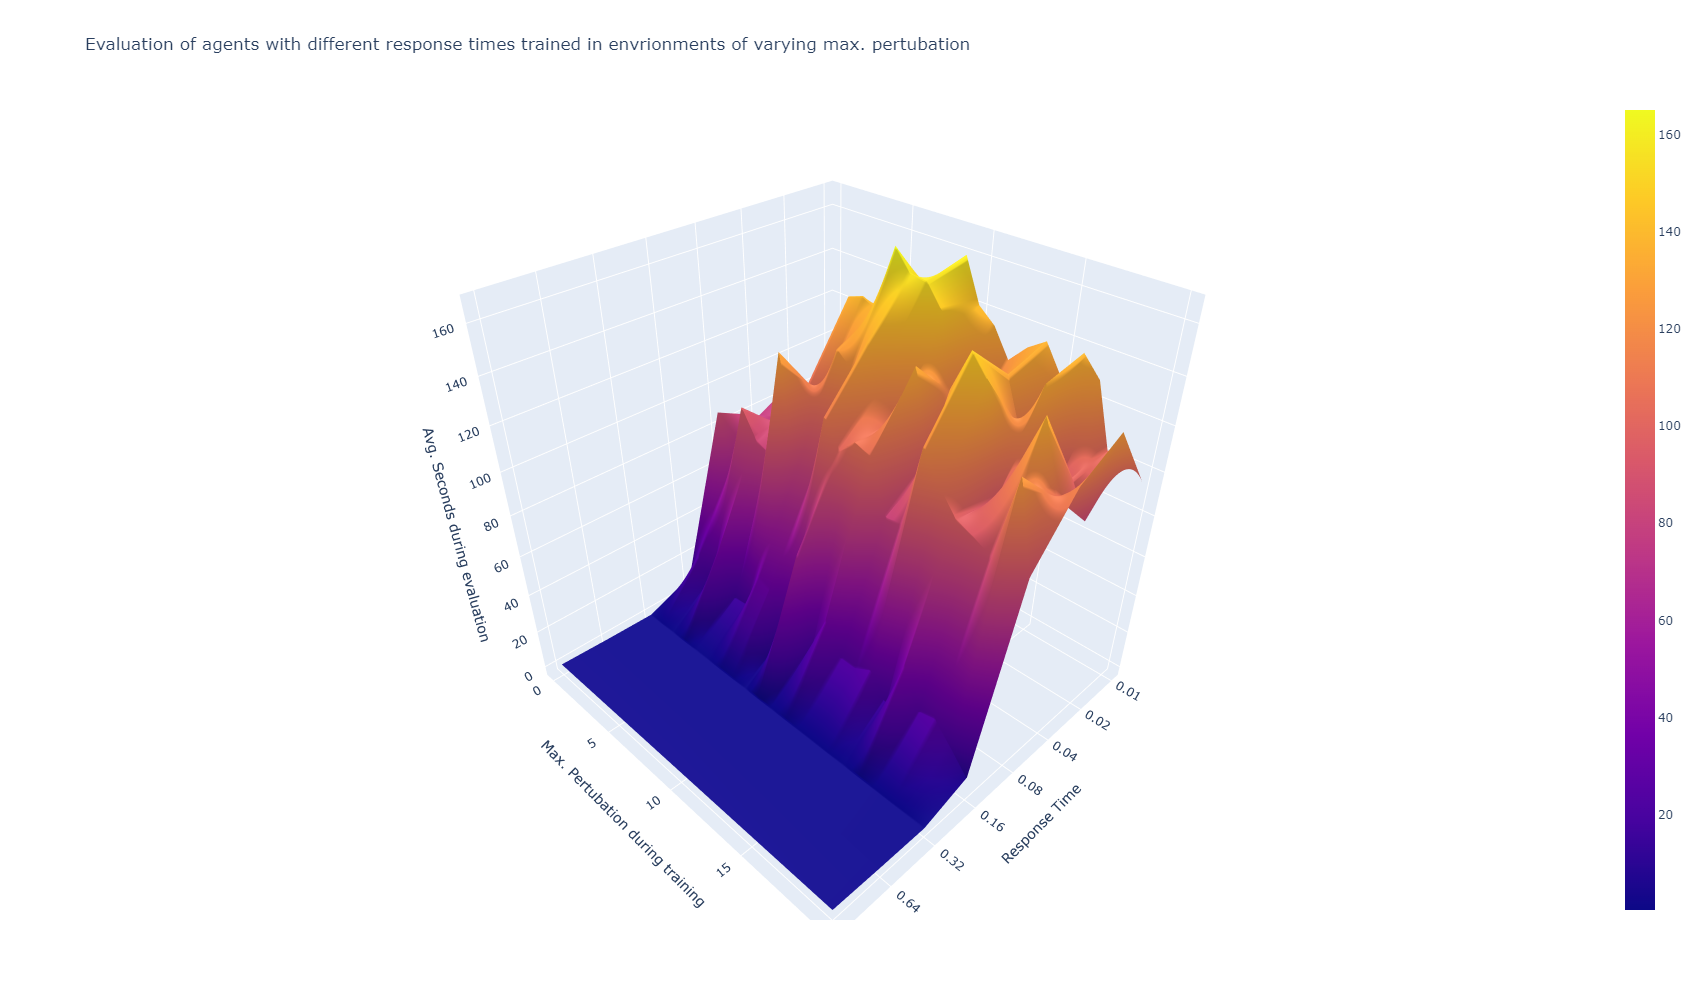

In [17]:
fig = go.Figure(data=[go.Surface(z=rewards, y=df['g_force'].unique(), x=df['response_rate'].unique())])

fig.update_layout(title='Evaluation of agents with different response times trained in envrionments of varying max. pertubation',
                  width=1000, height=1000)
fig.update_layout(
    scene = dict(
        xaxis = dict( type='log', title='Response Time', tickvals=df['response_rate'].unique()),
        yaxis = dict( title='Max. Pertubation during training'),
        zaxis = dict( title='Avg. Seconds during evaluation')))

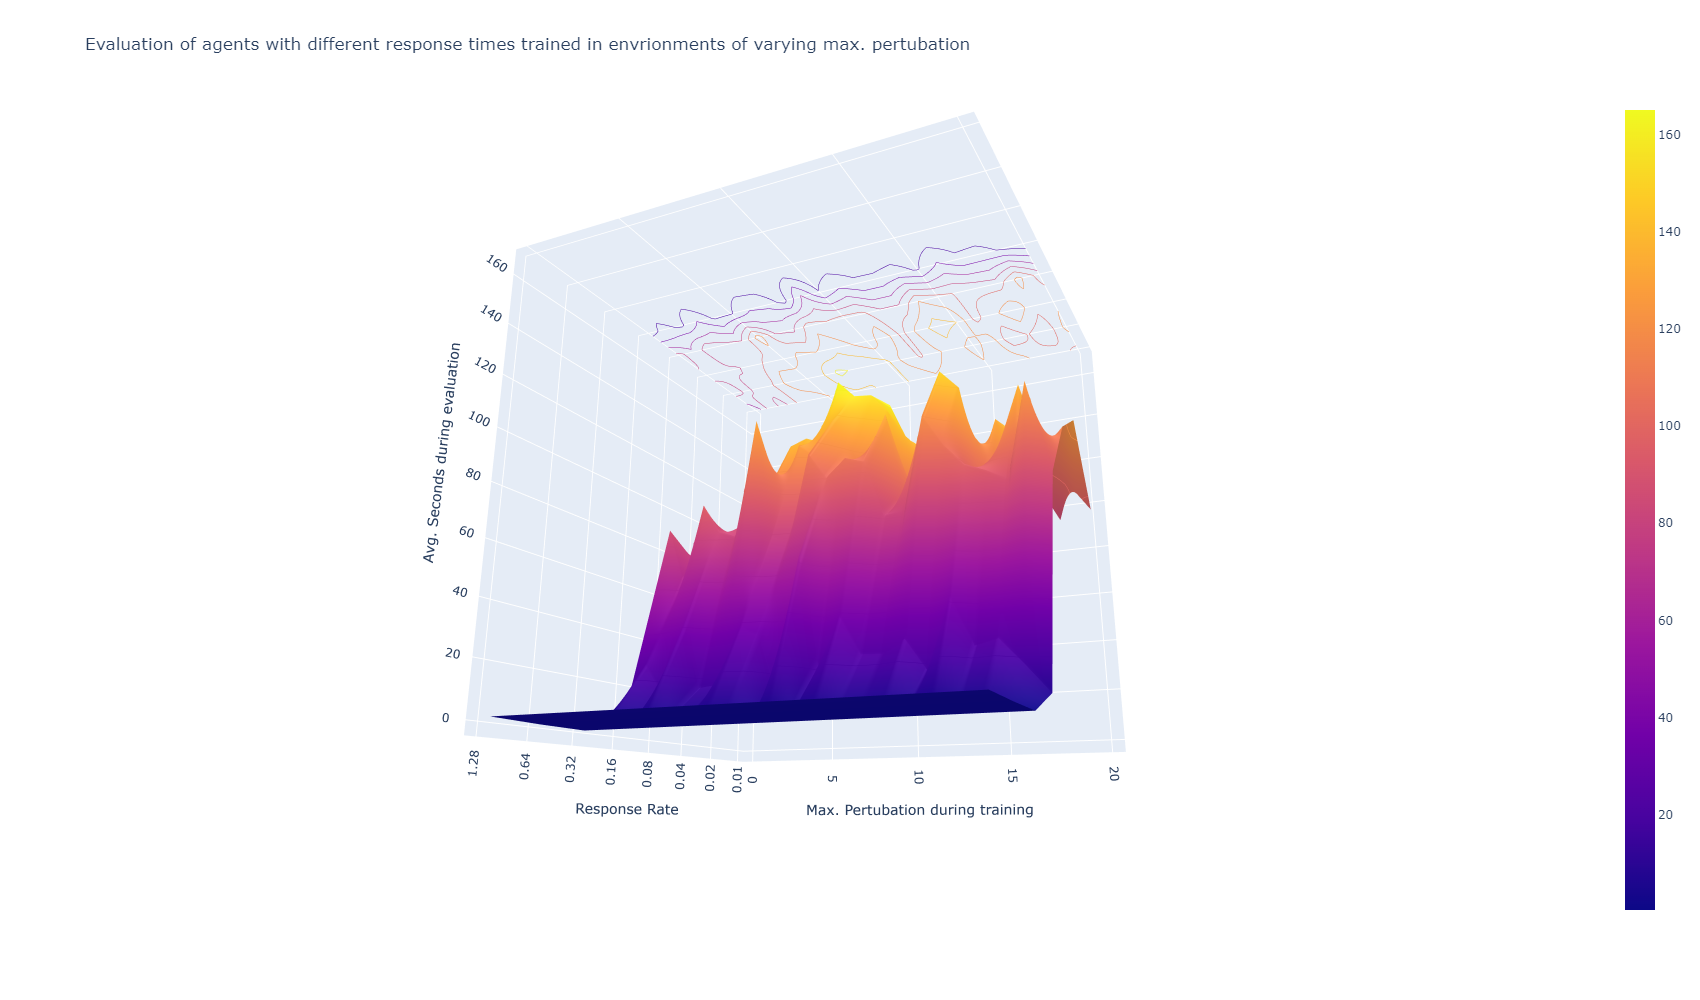

In [18]:
fig = go.Figure(data=[go.Surface(z=rewards, y=df['g_force'].unique(), x=df['response_rate'].unique())])

fig.update_layout(title='Evaluation of agents with different response times trained in envrionments of varying max. pertubation',
                  width=1000, height=1000, scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64))
fig.update_layout(
    scene = dict(
        xaxis = dict( type='log', title='Response Rate', tickvals=df['response_rate'].unique()),
        yaxis = dict( title='Max. Pertubation during training'),
        zaxis = dict( title='Avg. Seconds during evaluation')))
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="black", project_z=True))

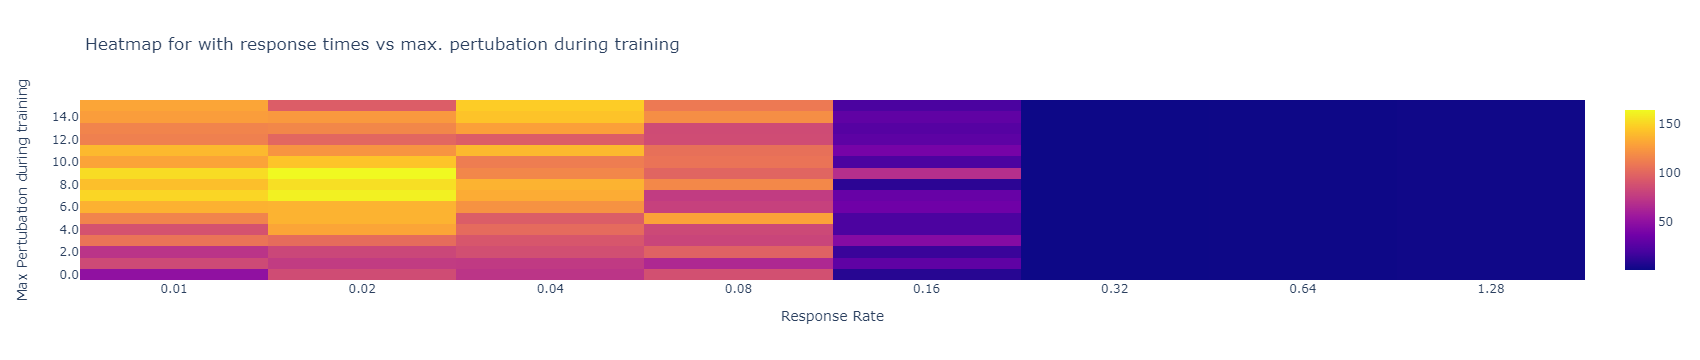

In [35]:
fig = go.Figure(data=go.Heatmap(
                    z=rewards, x=df['response_rate'].unique().astype('U'),
                   y=df['g_force'].unique().astype('U')))

fig.update_layout(
    title='Heatmap for with response times vs max. pertubation during training',
    xaxis_title="Response Rate",
    yaxis_title="Max Pertubation during training",
)

In [15]:
fig = ff.create_annotated_heatmap(z=rewards,y=df['g_force'].unique().astype('U').tolist(), x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  annotation_text=np.around(rewards, decimals=2), colorscale='greens')

fig.update_layout(
    title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Max Pertubation during training",
    xaxis_side='bottom',
    font=dict(size=18),
)
fig.show()

KeyError: 0.0

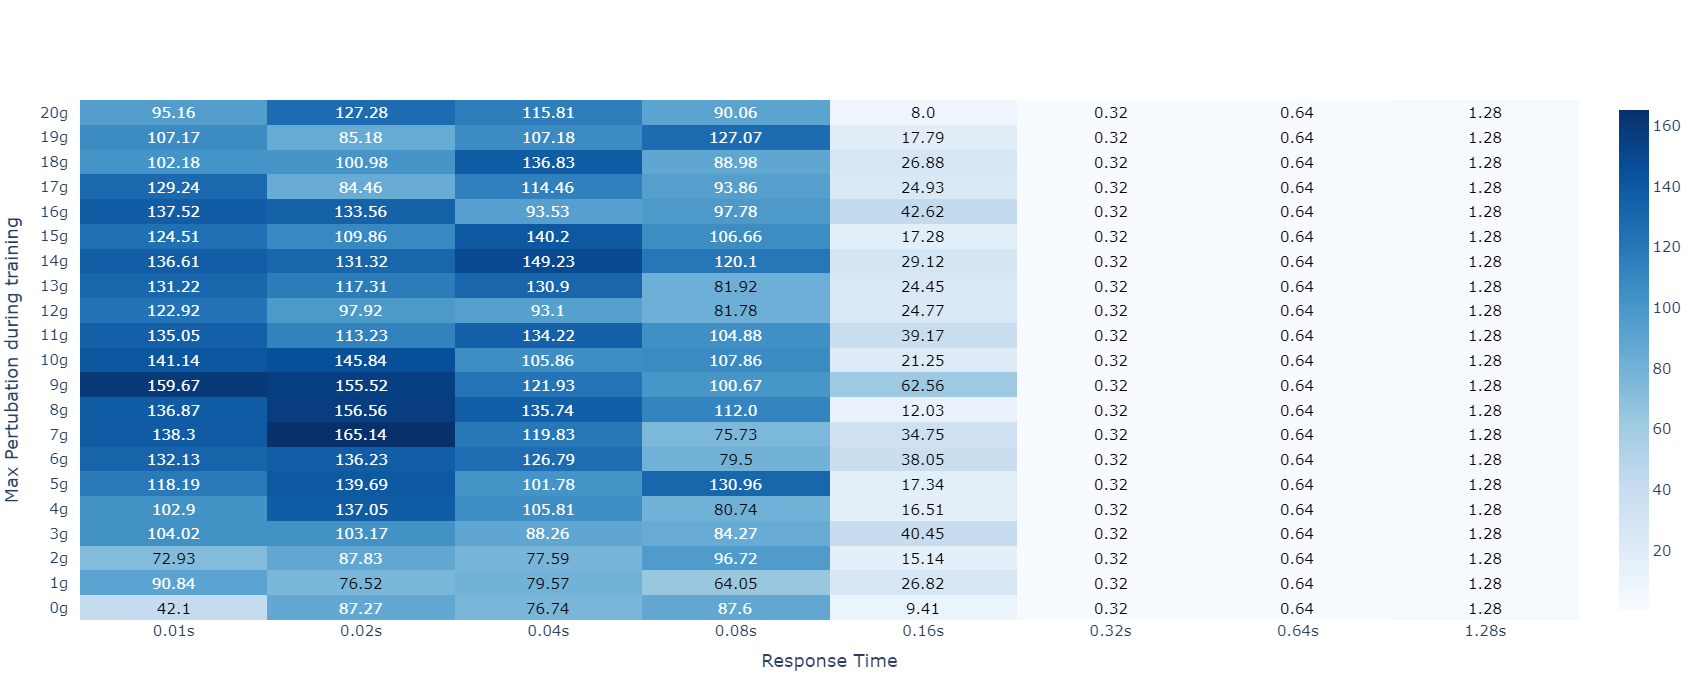

In [7]:
fig = ff.create_annotated_heatmap(z=rewards.to_numpy(),y=[str(int(i))+'g' for i in df['g_force'].unique().tolist()], 
                                  x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  
                                  annotation_text=np.around(rewards.to_numpy(), decimals=2), colorscale='blues', showscale=True,
                                 reversescale =False)

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Max Pertubation during training",
    xaxis_side='bottom',
    font=dict(size=15),
    height=700,
)
fig.show()



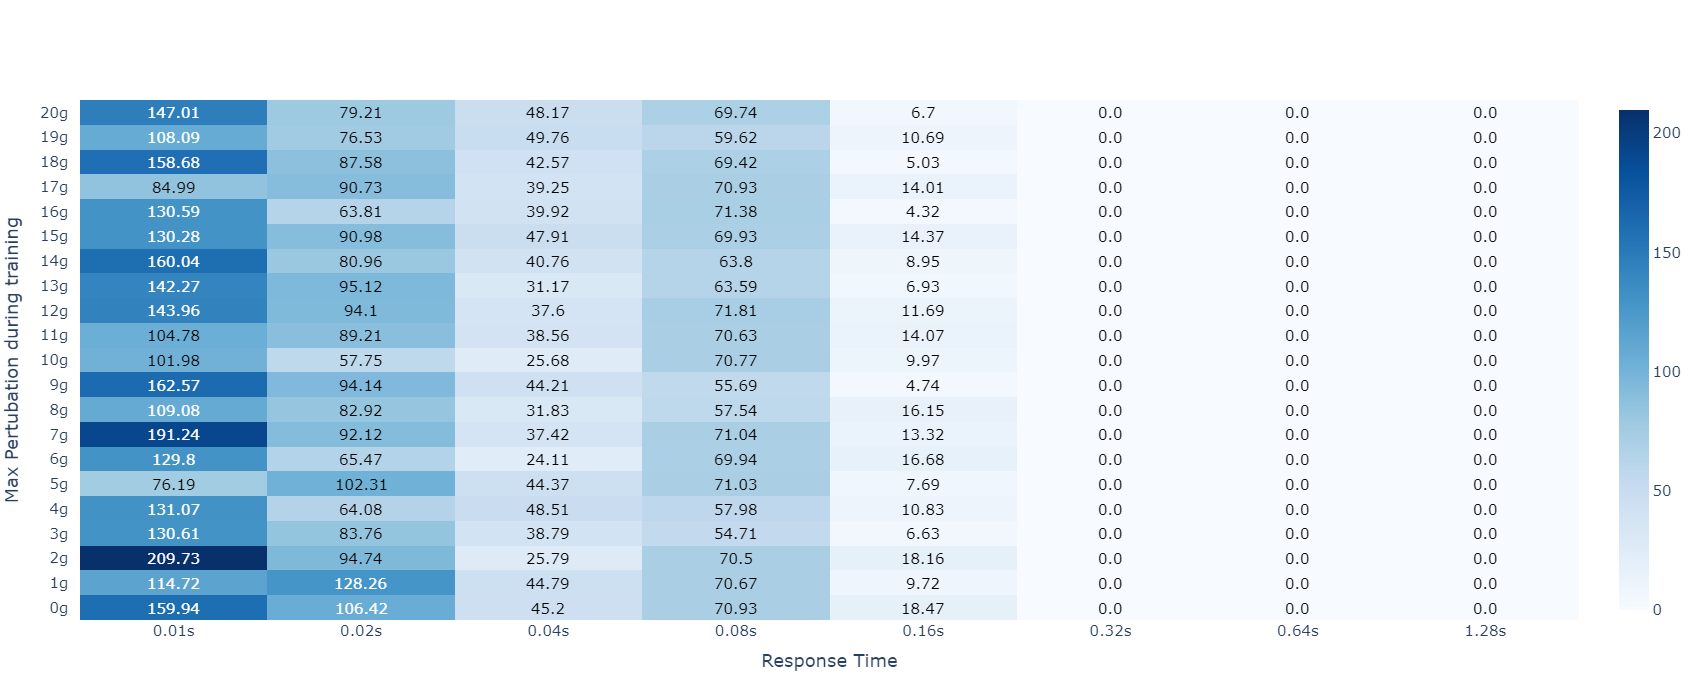

In [8]:
fig = ff.create_annotated_heatmap(z=jerks.to_numpy(),y=[str(int(i))+'g' for i in df['g_force'].unique().tolist()], 
                                  x=[str(i) + 's' for i in df['response_rate'].unique().tolist()],  
                                  annotation_text=np.around(jerks.to_numpy(), decimals=2), colorscale='blues', showscale=True,
                                 reversescale =False)

fig.update_layout(
#     title='Average evaluation seconds for response times vs max. pertubation during training',
    xaxis_title="Response Time",
    yaxis_title="Max Pertubation during training",
    xaxis_side='bottom',
    font=dict(size=15),
    height=700,
)
fig.show()



# Jerk

In [10]:
g_0 = df.loc[df['g_force'] == 0]

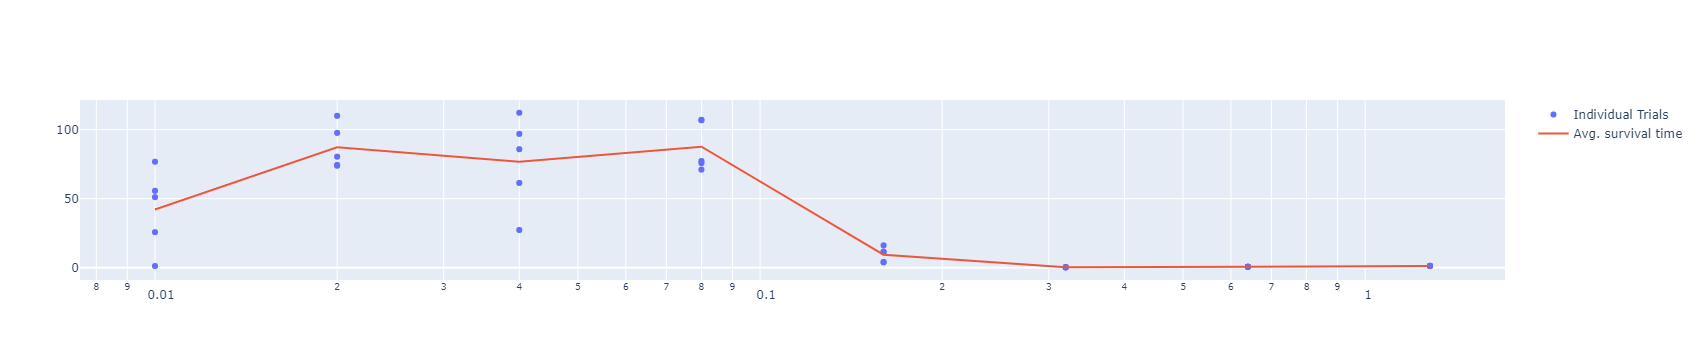

In [28]:
fig = go.Figure(data=go.Scatter(x=g_0['response_rate'], y=g_0['reward'], mode='markers', name='Individual Trials'))
fig.add_trace(go.Scatter(x=response_times, y=rewards.to_numpy()[0],
                    mode='lines',
                    name='Avg. survival time'))
fig.update_xaxes(type="log")

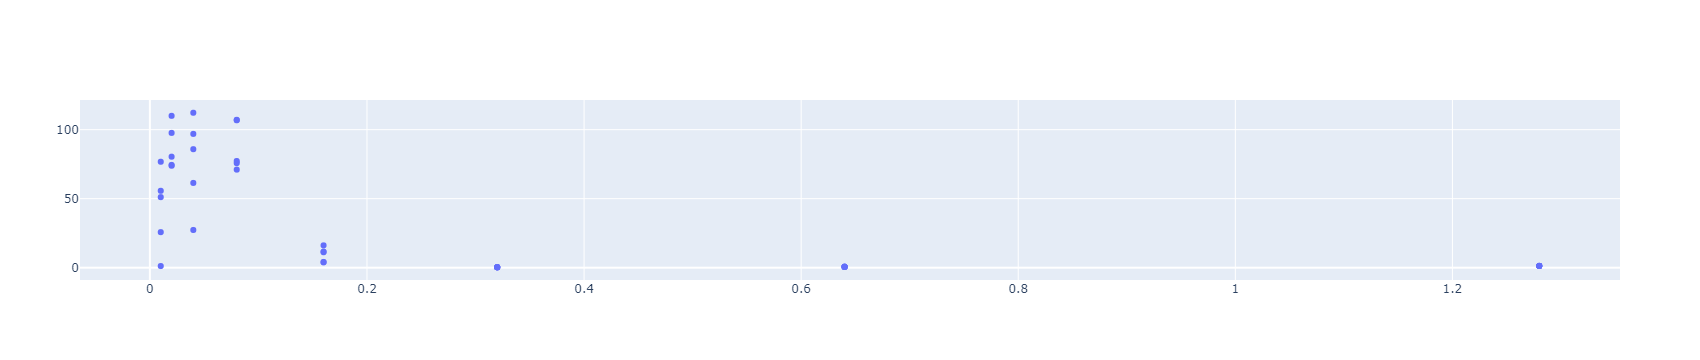

In [14]:
fig

In [24]:
rewards.to_numpy()[0]

array([42.102, 87.272, 76.744, 87.6  ,  9.408,  0.32 ,  0.64 ,  1.28 ])